In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Import Data

In [2]:
X_train = pd.read_csv('data_v1/train_all_feature.csv')

In [3]:
X_test= pd.read_csv('data_v1/test_all_feature.csv')

In [4]:
y_train = pd.read_csv('data_v1/y_train_new.csv')

In [5]:
y_test = pd.read_csv('data_v1/y_test_new.csv')

In [6]:
display(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4328, 105)

(1082, 105)

(4328, 1)

(1082, 1)

In [7]:
X_train.set_index('Provider',inplace = True)

In [8]:
X_test.set_index('Provider',inplace = True)

In [9]:
y_train = y_train.iloc[:,0].ravel() 

In [10]:
y_test = y_test.iloc[:,0].ravel()

In [11]:
# There are two null values under DeductibleAmtPaid_mean and DeductibleAmtPaid_max for PRV54673
# Fillna with -99
X_test.DeductibleAmtPaid_mean.fillna(0, inplace = True)
X_test.DeductibleAmtPaid_max.fillna(0, inplace = True)

In [12]:
Provider_train = list(X_train.index)

In [13]:
Provider_test = list(X_test.index)

In [14]:
set(Provider_train) & set(Provider_test)  #there is no overlap bewteen the providers in the train and test dataset.

set()

### 2. Original Dataset, balanced class weights, tuned hyperparameters

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
steps = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg', class_weight = 'balanced',random_state=42,max_iter=10000))]
model = Pipeline(steps)

In [16]:
train_scores = cross_val_score(model, X_train, y_train, scoring = 'average_precision', cv=5)
train_scores

array([0.88174766, 0.86323815, 0.80278395, 0.73953828, 0.75776653])

In [17]:
train_scores.mean()

0.8090149141291929

In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('rescale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='newton-cg'))])

In [19]:
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)

In [20]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)

In [24]:
# from sklearn.calibration import calibration_curve, CalibrationDisplay
# y_train_prob_1 = model.predict_proba(X_train)[:, 1]
# prob_true, prob_pred = calibration_curve(y_train, y_train_prob_1, n_bins=5)
# disp = CalibrationDisplay(prob_true, prob_pred, y_train_prob_1)
# disp.plot()

In [25]:
# from sklearn.calibration import calibration_curve, CalibrationDisplay
# y_test_prob_1 = model.predict_proba(X_test)[:, 1]
# prob_true, prob_pred = calibration_curve(y_test, y_test_prob_1, n_bins=5)
# disp = CalibrationDisplay(prob_true, prob_pred, y_test_prob_1)
# disp.plot()

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score_train1 = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])  
roc_auc_score_test1 = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train1))
print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test1))

roc_auc_score for the train dataset: 0.98
roc_auc_score for the test dataset: 0.99


Text(0.5, 1.0, 'Train ROC Curve, all features')

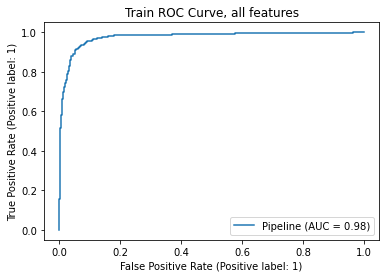

In [22]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_train, y_train)
plt.title("Train ROC Curve, all features")

Text(0.5, 1.0, 'Test ROC Curve, all features')

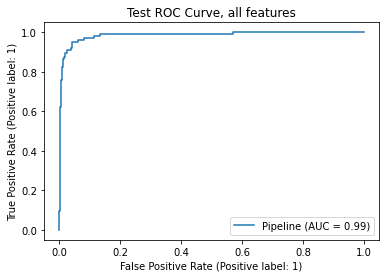

In [23]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("Test ROC Curve, all features")

Test PR-AUC is 0.92
min threshold:0.00 max threshold:0.98


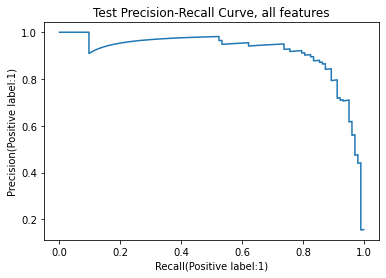

In [24]:
from sklearn.metrics import auc,plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

y_score1 = y_test_proba[:, 1]
test_precision1, test_recall1, test_thresholds1 = precision_recall_curve(y_test, y_score1)
test_auc_precision_recall1 = auc(test_recall1, test_precision1)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall1))

print('min threshold:{:.2f}'.format(min(test_thresholds1)), 'max threshold:{:.2f}'.format(max(test_thresholds1)))

plt.plot(test_recall1, test_precision1)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, all features')
plt.show()

Train PR-AUC is 0.85
min threshold:0.00 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, all features')

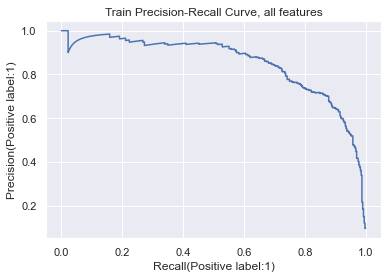

In [137]:
# plot train PR Curve 
train_precision1, train_recall1, train_thresholds1 = precision_recall_curve(y_train, y_train_proba[:, 1])
train_auc_precision_recall1 = auc(train_recall1, train_precision1)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall1))

print('min threshold:{:.2f}'.format(min(train_thresholds1)), 'max threshold:{:.2f}'.format(max(train_thresholds1)))

plt.plot(train_recall1, train_precision1)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, all features')

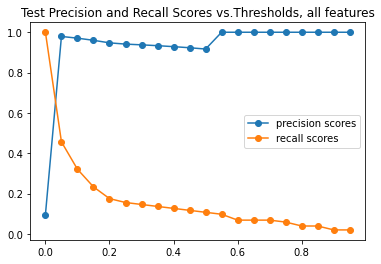

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores = []
recall_scores = []

for i in range(len(thresholds)):
    y_test_pred_new = (model.predict_proba(X_test)[:,1]>thresholds[i]).astype(int)
    prec_scores.append(precision_score(y_test, y_test_pred_new))
    recall_scores.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, all features')
plt.show()

In [27]:
importances = model.named_steps['logreg'].coef_[0]
features = model.feature_names_in_
logreg_importances = pd.Series(importances, index = features)
logreg_importances.sort_values(ascending = False)

TotalTeDiagCode                   2.286210
TotalTeProcCode                   1.217291
MaxHospitalDays                   1.194729
MaxDiagCodeNumPerClaim            0.985291
ClmsperBene                       0.535640
                                    ...   
MeanLowFreqDiagCodeNumPerClaim   -0.375553
MajorRace                        -0.405068
uniqBeneCount                    -0.451041
MedianHospitalDays               -0.743125
MeanProcCodeNumPerClaim          -0.889669
Length: 104, dtype: float64

In [38]:
#fig = plt.figure(figsize = (15,6))
#logreg_importances2.plot.bar(title = 'Feature Importance with balanced class weight')

In [28]:
importances_abs = np.absolute(model.named_steps['logreg'].coef_[0])
logreg_importances_abs = pd.Series(importances_abs, index = features)
top50features = logreg_importances_abs.sort_values(ascending = False)[:50].index

In [29]:
top50features = list(top50features)

In [30]:
logreg_importances.loc[top50features]

TotalTeDiagCode                      2.286210
TotalTeProcCode                      1.217291
MaxHospitalDays                      1.194729
MaxDiagCodeNumPerClaim               0.985291
MeanProcCodeNumPerClaim             -0.889669
MedianHospitalDays                  -0.743125
ClmsperBene                          0.535640
uniqBeneCount                       -0.451041
totalDiagCode_42731                  0.425415
MajorRace                           -0.405068
totalDiagCode_2589                   0.394256
MeanLowFreqDiagCodeNumPerClaim      -0.375553
OPAnnualDeductibleAmt_sum            0.374136
InClmsPct                           -0.345850
TotalInscClaimAmtReimbursed          0.338991
totalDiagCode_41401                  0.331226
OPAnnualReimbursementAmt_sum         0.328806
Chronic_Heartfailure_Frac            0.327246
Chronic_KidneyDisease_Frac           0.310395
MaxInscClaimAmtReimbursed            0.279216
totalDiagCode_2724                  -0.278527
DeductibleAmtPaid_mean            

Text(0.5, 0, 'coefficient')

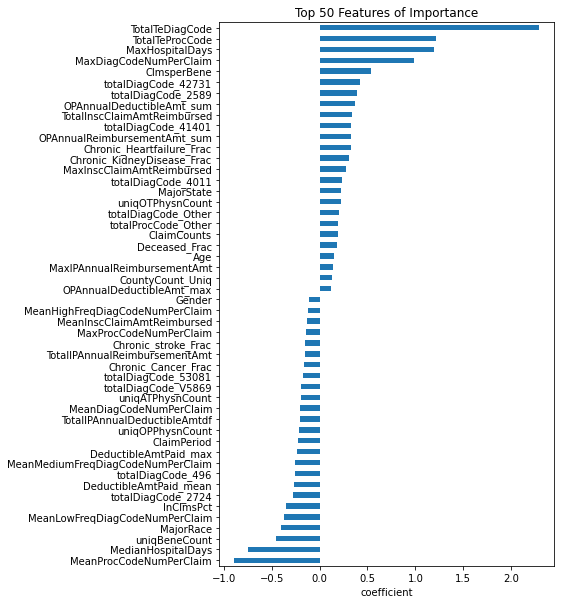

In [31]:
fig = plt.figure(figsize = (6,10))
logreg_importances.loc[top50features].sort_values(ascending = True).plot.barh(title = 'Top 50 Features of Importance')
plt.xlabel('coefficient')

<AxesSubplot:title={'center':'Top 50 Features of Importance'}>

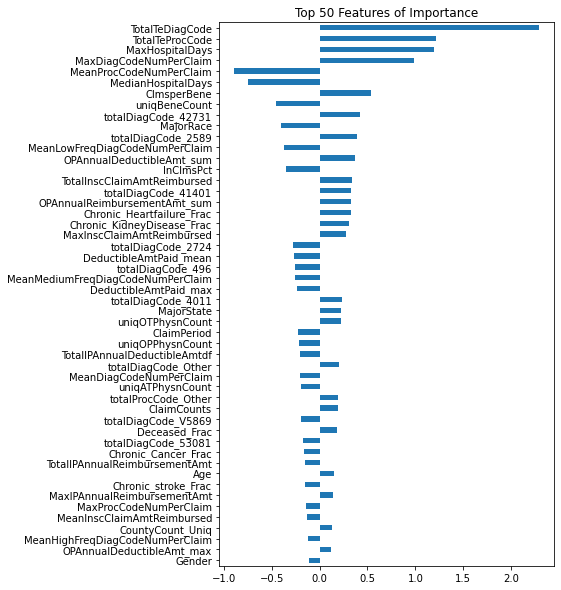

In [32]:
fig = plt.figure(figsize = (6,10))
logreg_importances.loc[top50features][::-1].plot.barh(title = 'Top 50 Features of Importance')

In [33]:
top50features = logreg_importances_abs.sort_values(ascending = False)[:50].index

### 2. Remove the TargetEncoded Features, 102 features

In [36]:
features = list(X_train.columns)

In [37]:
features2= features[:-2]

In [38]:
X_train2 = X_train[features2]

In [39]:
X_test2 = X_test[features2]

In [40]:
display(X_train2.shape, X_test2.shape)

(4328, 102)

(1082, 102)

In [41]:
display(y_train.shape, y_test.shape)

(4328,)

(1082,)

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

steps2 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
model2 = Pipeline(steps2)
model2_gsv = GridSearchCV(model2,param_grid,cv = 5, scoring = 'average_precision')
model2_gsv.fit(X_train2, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rescale', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             param_grid={'logreg__C': [10, 1.0, 0.1, 0.01, 0.005],
                         'logreg__penalty': ['l2'],
                         'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga']},
             scoring='average_precision')

In [43]:
model2_gsv.best_params_

{'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

In [44]:
steps2 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.01, penalty = 'l2', solver = 'liblinear', class_weight = 'balanced',random_state=42,max_iter=10000))]
model2 = Pipeline(steps2)

In [45]:
train_scores2 = cross_val_score(model2, X_train2, y_train, scoring = 'average_precision', cv=5)

In [46]:
train_scores2.mean()

0.7254430140362971

In [47]:
model2.fit(X_train2, y_train)

Pipeline(steps=[('rescale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='liblinear'))])

In [48]:
y_train_pred2 = model2.predict(X_train2)
y_train_proba2 = model2.predict_proba(X_train2)

In [49]:
y_test_pred2 = model2.predict(X_test2)
y_test_proba2 = model2.predict_proba(X_test2)

In [50]:
roc_auc_score_train2 = roc_auc_score(y_train, model2.predict_proba(X_train2)[:, 1])  
roc_auc_score_test2 = roc_auc_score(y_test, model2.predict_proba(X_test2)[:, 1])
print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train2))
print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test2))

roc_auc_score for the train dataset: 0.96
roc_auc_score for the test dataset: 0.95


Text(0.5, 1.0, 'Train ROC Curve, all features wo 2 targetEncoded features')

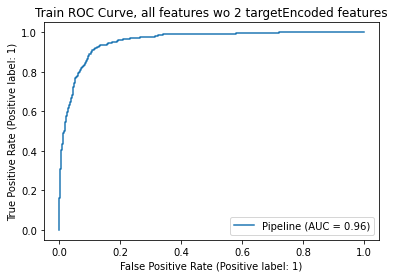

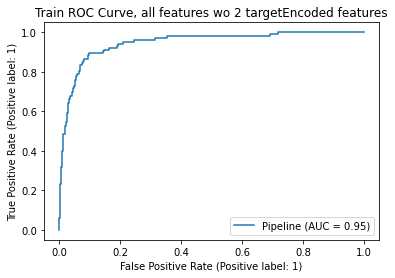

In [51]:
RocCurveDisplay.from_estimator(model2, X_train2, y_train)
plt.title("Train ROC Curve, all features wo 2 targetEncoded features")
RocCurveDisplay.from_estimator(model2, X_test2, y_test)
plt.title("Train ROC Curve, all features wo 2 targetEncoded features")

Test PR-AUC is 0.71
min threshold:0.08 max threshold:1.00


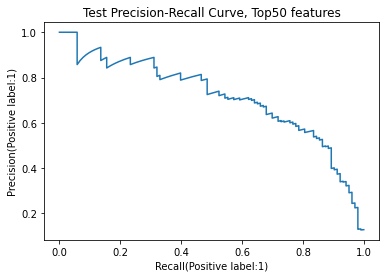

In [52]:
from sklearn.metrics import auc,plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

y_test_score2 = y_test_proba2[:, 1]
test_precision2, test_recall2, test_thresholds2 = precision_recall_curve(y_test, y_test_score2)
test_auc_precision_recall2 = auc(test_recall2, test_precision2)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall2))

print('min threshold:{:.2f}'.format(min(test_thresholds2)), 'max threshold:{:.2f}'.format(max(test_thresholds2)))

plt.plot(test_recall2, test_precision2)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top50 features')
plt.show()

Train PR-AUC is 0.74
min threshold:0.07 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top50 features')

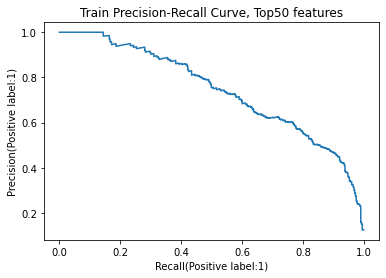

In [53]:
# plot train PR Curve 
train_precision2, train_recall2, train_thresholds2 = precision_recall_curve(y_train, y_train_proba2[:, 1])
train_auc_precision_recall2 = auc(train_recall2, train_precision2)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall2))

print('min threshold:{:.2f}'.format(min(train_thresholds2)), 'max threshold:{:.2f}'.format(max(train_thresholds2)))

plt.plot(train_recall2, train_precision2)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top50 features')

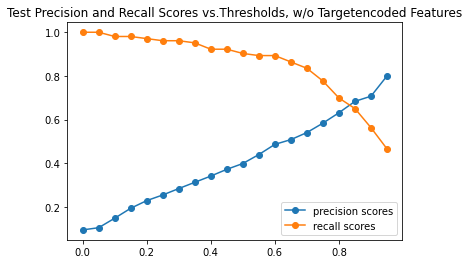

In [83]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores2 = []
recall_scores2 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model2.predict_proba(X_test2)[:,1]>thresholds[i]).astype(int)
    prec_scores2.append(precision_score(y_test, y_test_pred_new))
    recall_scores2.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores2, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores2,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, w/o Targetencoded Features')
plt.show()

## New feature importance without target encoded features

In [60]:
importances2 = model2.named_steps['logreg'].coef_[0]
features2 = model2.feature_names_in_
logreg_importances2 = pd.Series(importances2, index = features2)
logreg_importances2.sort_values(ascending = False)

MaxHospitalDays                   0.806495
ClmsperBene                       0.329917
MaxInscClaimAmtReimbursed         0.274917
totalDiagCode_41401               0.182675
totalDiagCode_42731               0.181236
                                    ...   
uniqATPhysnCount                 -0.074346
MaxIPAnnualDeductibleAmt         -0.087914
MeanLowFreqDiagCodeNumPerClaim   -0.096184
uniqBeneCount                    -0.164368
MedianHospitalDays               -0.293488
Length: 102, dtype: float64

In [61]:
importances_abs2 = np.absolute(model2.named_steps['logreg'].coef_[0])
logreg_importances_abs2 = pd.Series(importances_abs2, index = features2)
top50features2 = logreg_importances_abs2.sort_values(ascending = False)[:50].index

In [62]:
top50features2 = list(top50features2)

In [63]:
top50features2

['MaxHospitalDays',
 'ClmsperBene',
 'MedianHospitalDays',
 'MaxInscClaimAmtReimbursed',
 'totalDiagCode_41401',
 'totalDiagCode_42731',
 'MajorState',
 'TotalMediumHighFreqProcCodeNumPerClaim',
 'uniqBeneCount',
 'TotalInscClaimAmtReimbursed',
 'totalDiagCode_2589',
 'Chronic_Heartfailure_Frac',
 'OPAnnualDeductibleAmt_sum',
 'OPAnnualReimbursementAmt_sum',
 'MaxDiagCodeNumPerClaim',
 'Chronic_KidneyDisease_Frac',
 'MeanLowFreqDiagCodeNumPerClaim',
 'MaxIPAnnualDeductibleAmt',
 'TotalProcCodeNum',
 'NoOfMonths_PartACov_mean',
 'CountyCount_Uniq',
 'MeanRareFreqDiagCodeNumPerClaim',
 'uniqATPhysnCount',
 'totalDiagCode_Other',
 'totalProcCode_Other',
 'ClaimCounts',
 'TotalMediumFreqProcCodeNumPerClaim',
 'RenalDiseaseIndicator',
 'totalDiagCode_4011',
 'TotalDiagCodeNum',
 'totalDiagCode_4280',
 'MajorRace',
 'Chronic_stroke_Frac',
 'totalDiagCode_496',
 'uniqOPPhysnCount',
 'Chronic_Cancer_Frac',
 'totalDiagCode_V5861',
 'MeanHospitalDays',
 'DeductibleAmtPaid_mean',
 'RaceOneFrac',


<AxesSubplot:title={'center':'Top 50 Features of Importance'}>

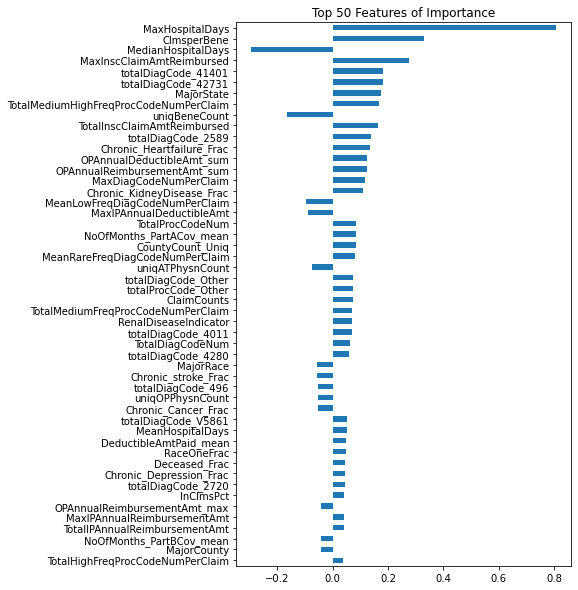

In [66]:
fig = plt.figure(figsize = (6,10))
logreg_importances2.loc[top50features2][::-1].plot.barh(title = 'Top 50 Features of Importance')

### Logistic Regression with Top50Features, no target encoded features

In [68]:
top50features2 = logreg_importances_abs2.sort_values(ascending = False)[:50].index
top50features2= list(top50features2)

X_train_top50_2 = X_train[top50features2]
X_test_top50_2 = X_test[top50features2]

display(X_train_top50_2.shape, X_test_top50_2.shape)

(4328, 50)

(1082, 50)

In [69]:
param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

steps3 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
model3 = Pipeline(steps3)
model3_gsv = GridSearchCV(model3,param_grid,cv = 5, scoring = 'average_precision')
model3_gsv.fit(X_train_top50_2, y_train)
model3_gsv.best_params_

{'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}

In [71]:
steps3 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.01, penalty = 'l2', solver = 'saga', class_weight = 'balanced',random_state=42,max_iter=10000))]
model3 = Pipeline(steps3)

In [72]:
train_scores3 = cross_val_score(model3, X_train_top50_2, y_train, scoring = 'average_precision', cv=5)
train_scores3.mean()

0.7339157578721098

In [75]:
model3.fit(X_train_top50_2,y_train)

y_train_pred3 = model3.predict(X_train_top50_2)
y_train_proba3 = model3.predict_proba(X_train_top50_2)

y_test_pred3 = model3.predict(X_test_top50_2)
y_test_proba3 = model3.predict_proba(X_test_top50_2)

Text(0.5, 1.0, 'Train ROC Curve, Top 50 w/o Target-encoded features')

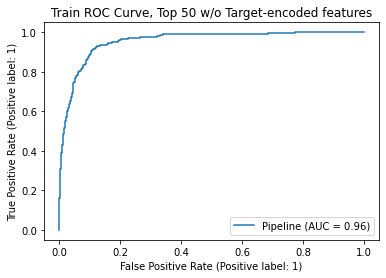

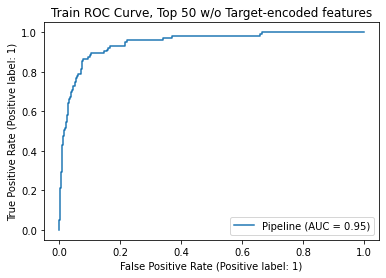

In [82]:
#ROC Curve
RocCurveDisplay.from_estimator(model3, X_train_top50_2, y_train)
plt.title("Train ROC Curve, Top 50 w/o Target-encoded features")
RocCurveDisplay.from_estimator(model3, X_test_top50_2, y_test)
plt.title("Train ROC Curve, Top 50 w/o Target-encoded features")

Train PR-AUC is 0.74
min threshold:0.03 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top 50 w/o target-encoded Features')

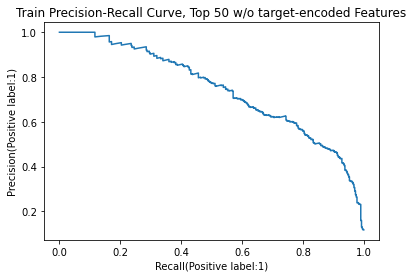

In [81]:
# plot train PR Curve 
train_precision3, train_recall3, train_thresholds3 = precision_recall_curve(y_train, y_train_proba3[:, 1])
train_auc_precision_recall3 = auc(train_recall3, train_precision3)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall3))

print('min threshold:{:.2f}'.format(min(train_thresholds3)), 'max threshold:{:.2f}'.format(max(train_thresholds3)))

plt.plot(train_recall3, train_precision3)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top 50 w/o target-encoded Features')

Test PR-AUC is 0.71
min threshold:0.05 max threshold:1.00


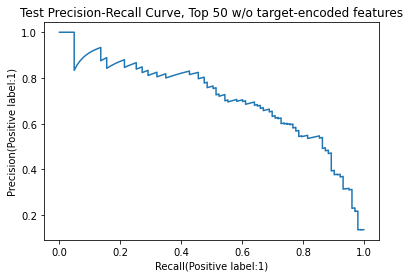

In [80]:
#plot test PR Curve
test_precision3, test_recall3, test_thresholds3 = precision_recall_curve(y_test, y_test_proba3[:, 1])
test_auc_precision_recall3 = auc(test_recall3, test_precision3)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall3))

print('min threshold:{:.2f}'.format(min(test_thresholds3)), 'max threshold:{:.2f}'.format(max(test_thresholds3)))

plt.plot(test_recall3, test_precision3)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top 50 w/o target-encoded features')
plt.show()

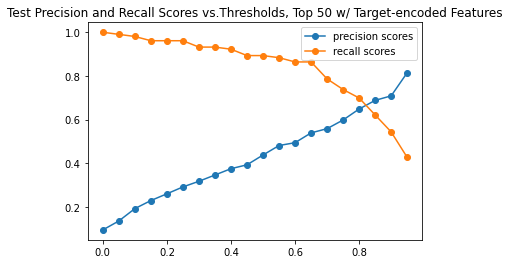

In [79]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores3 = []
recall_scores3 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model3.predict_proba(X_test_top50_2)[:,1]>thresholds[i]).astype(int)
    prec_scores3.append(precision_score(y_test, y_test_pred_new))
    recall_scores3.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores3, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores3,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 50 w/ Target-encoded Features')
plt.show()

### Logistic Regression with Top 30 w/o Target-Encoded Features

In [84]:
top30features2 = logreg_importances_abs2.sort_values(ascending = False)[:30].index
top30features2= list(top30features2)

X_train_top30_2 = X_train[top30features2]
X_test_top30_2 = X_test[top30features2]

display(X_train_top30_2.shape, X_test_top30_2.shape)

(4328, 30)

(1082, 30)

In [85]:
param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

steps4 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
model4 = Pipeline(steps4)
model4_gsv = GridSearchCV(model4,param_grid,cv = 5, scoring = 'average_precision')
model4_gsv.fit(X_train_top30_2, y_train)
model4_gsv.best_params_

{'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'sag'}

In [86]:
steps4 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.01, penalty = 'l2', solver = 'sag', class_weight = 'balanced',random_state=42,max_iter=10000))]
model4 = Pipeline(steps4)

In [87]:
train_scores4 = cross_val_score(model4, X_train_top30_2, y_train, scoring = 'average_precision', cv=5)
train_scores4.mean()

0.7367605868520468

In [88]:
model4.fit(X_train_top30_2,y_train)

y_train_pred4 = model4.predict(X_train_top30_2)
y_train_proba4 = model4.predict_proba(X_train_top30_2)

y_test_pred4 = model4.predict(X_test_top30_2)
y_test_proba4 = model4.predict_proba(X_test_top30_2)

Text(0.5, 1.0, 'Train ROC Curve, Top 30 w/o Target-encoded features')

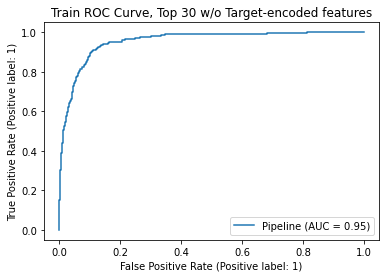

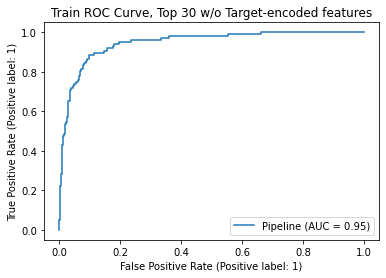

In [94]:
#ROC Curve
RocCurveDisplay.from_estimator(model4, X_train_top30_2, y_train)
plt.title("Train ROC Curve, Top 30 w/o Target-encoded features")
RocCurveDisplay.from_estimator(model4, X_test_top30_2, y_test)
plt.title("Train ROC Curve, Top 30 w/o Target-encoded features")

Train PR-AUC is 0.74
min threshold:0.03 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top30 w/o Target-encoded Features')

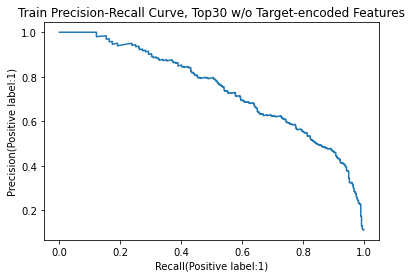

In [95]:
# plot train PR Curve 
train_precision4, train_recall4, train_thresholds4 = precision_recall_curve(y_train, y_train_proba4[:, 1])
train_auc_precision_recall4 = auc(train_recall4, train_precision4)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall4))

print('min threshold:{:.2f}'.format(min(train_thresholds4)), 'max threshold:{:.2f}'.format(max(train_thresholds4)))

plt.plot(train_recall4, train_precision4)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top30 w/o Target-encoded Features')

Test PR-AUC is 0.71
min threshold:0.05 max threshold:1.00


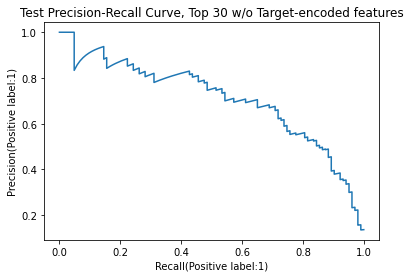

In [96]:
test_precision4, test_recall4, test_thresholds4 = precision_recall_curve(y_test, y_test_proba4[:, 1])
test_auc_precision_recall4 = auc(test_recall4, test_precision4)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall4))

print('min threshold:{:.2f}'.format(min(test_thresholds4)), 'max threshold:{:.2f}'.format(max(test_thresholds4)))

plt.plot(test_recall4, test_precision4)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top 30 w/o Target-encoded features')
plt.show()

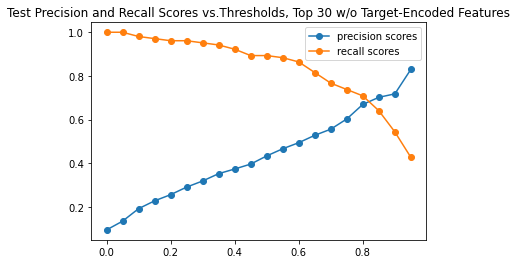

In [98]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores4 = []
recall_scores4 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model4.predict_proba(X_test_top30_2)[:,1]>thresholds[i]).astype(int)
    prec_scores4.append(precision_score(y_test, y_test_pred_new))
    recall_scores4.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores4, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores4,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 30 w/o Target-Encoded Features')
plt.show()

### Logistic Regression with Top 15 w/o Target-Encoded Features

In [100]:
top15features2 = logreg_importances_abs2.sort_values(ascending = False)[:15].index
top15features2= list(top15features2)

X_train_top15_2 = X_train[top15features2]
X_test_top15_2 = X_test[top15features2]

display(X_train_top15_2.shape, X_test_top15_2.shape)

(4328, 15)

(1082, 15)

In [101]:
from sklearn.model_selection import GridSearchCV
param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

steps5 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
model5 = Pipeline(steps5)
model5_gsv = GridSearchCV(model5,param_grid,cv = 5, scoring = 'average_precision')
model5_gsv.fit(X_train_top15_2, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rescale', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           random_state=42))]),
             param_grid={'logreg__C': [10, 1.0, 0.1, 0.01, 0.005],
                         'logreg__penalty': ['l2'],
                         'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga']},
             scoring='average_precision')

In [102]:
model5_gsv.best_params_

{'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

In [104]:
steps5 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.01, penalty = 'l2', solver = 'liblinear', class_weight = 'balanced',random_state=42,max_iter=10000))]
model5 = Pipeline(steps5)

In [105]:
train_scores5 = cross_val_score(model5, X_train_top15_2, y_train, scoring = 'average_precision', cv=5)
train_scores5.mean()

0.7349786886326194

In [106]:
model5.fit(X_train_top15_2,y_train)

y_train_pred5 = model5.predict(X_train_top15_2)
y_train_proba5 = model5.predict_proba(X_train_top15_2)

y_test_pred5 = model5.predict(X_test_top15_2)
y_test_proba5 = model5.predict_proba(X_test_top15_2)

Text(0.5, 1.0, 'Train ROC Curve, Top 15 w/o Target-encoded features')

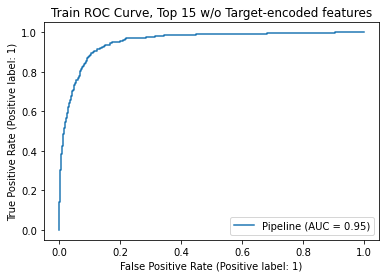

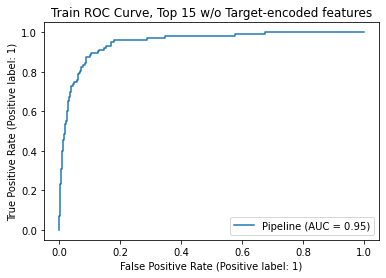

In [108]:
#ROC Curve
RocCurveDisplay.from_estimator(model5, X_train_top15_2, y_train)
plt.title("Train ROC Curve, Top 15 w/o Target-encoded features")
RocCurveDisplay.from_estimator(model5, X_test_top15_2, y_test)
plt.title("Train ROC Curve, Top 15 w/o Target-encoded features")

Train PR-AUC is 0.74
min threshold:0.05 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top 15 w/o Target-encoded Features')

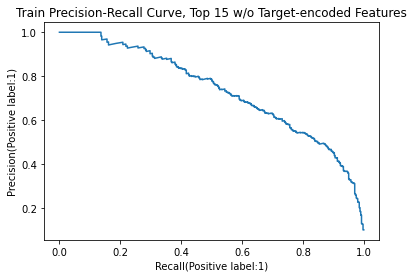

In [109]:
# plot train PR Curve 
train_precision5, train_recall5, train_thresholds5 = precision_recall_curve(y_train, y_train_proba5[:, 1])
train_auc_precision_recall5 = auc(train_recall5, train_precision5)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall5))

print('min threshold:{:.2f}'.format(min(train_thresholds5)), 'max threshold:{:.2f}'.format(max(train_thresholds5)))

plt.plot(train_recall5, train_precision5)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top 15 w/o Target-encoded Features')

Test PR-AUC is 0.71
min threshold:0.09 max threshold:1.00


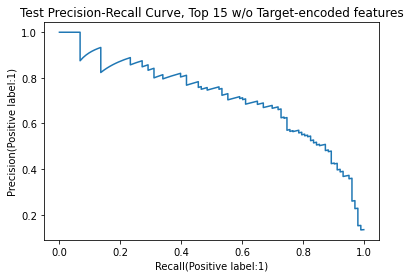

In [110]:
test_precision5, test_recall5, test_thresholds5 = precision_recall_curve(y_test, y_test_proba5[:, 1])
test_auc_precision_recall5 = auc(test_recall5, test_precision5)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall5))

print('min threshold:{:.2f}'.format(min(test_thresholds5)), 'max threshold:{:.2f}'.format(max(test_thresholds5)))

plt.plot(test_recall5, test_precision5)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top 15 w/o Target-encoded features')
plt.show()

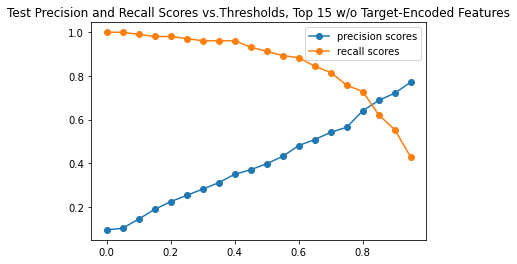

In [111]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores5 = []
recall_scores5 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model5.predict_proba(X_test_top15_2)[:,1]>thresholds[i]).astype(int)
    prec_scores5.append(precision_score(y_test, y_test_pred_new))
    recall_scores5.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores5, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores5,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 15 w/o Target-Encoded Features')
plt.show()

### Logistic Regression with Top 10 w/o Target-Encoded Features

In [113]:
top10features2 = logreg_importances_abs2.sort_values(ascending = False)[:10].index
top10features2= list(top10features2)

X_train_top10_2 = X_train[top10features2]
X_test_top10_2 = X_test[top10features2]

display(X_train_top10_2.shape, X_test_top10_2.shape)

(4328, 10)

(1082, 10)

In [114]:
from sklearn.model_selection import GridSearchCV
param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

steps6 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
model6 = Pipeline(steps6)
model6_gsv = GridSearchCV(model6,param_grid,cv = 5, scoring = 'average_precision')
model6_gsv.fit(X_train_top10_2, y_train)
model6_gsv.best_params_

{'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

In [115]:
steps6 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.01, penalty = 'l2', solver = 'liblinear', class_weight = 'balanced',random_state=42,max_iter=10000))]
model6 = Pipeline(steps6)
train_scores6= cross_val_score(model6, X_train_top10_2, y_train, scoring = 'average_precision', cv=5)
train_scores6.mean()

0.7286268655392591

In [116]:
model6.fit(X_train_top10_2, y_train)

y_train_pred6 = model6.predict(X_train_top10_2)
y_train_proba6 = model6.predict_proba(X_train_top10_2)

y_test_pred6 = model6.predict(X_test_top10_2)
y_test_proba6 = model6.predict_proba(X_test_top10_2)

Text(0.5, 1.0, 'Train ROC Curve, Top 10 w/o Target-encoded features')

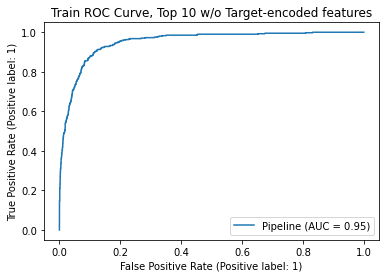

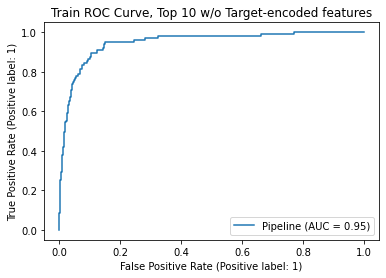

In [117]:
#ROC Curve
RocCurveDisplay.from_estimator(model6, X_train_top10_2, y_train)
plt.title("Train ROC Curve, Top 10 w/o Target-encoded features")
RocCurveDisplay.from_estimator(model6, X_test_top10_2, y_test)
plt.title("Train ROC Curve, Top 10 w/o Target-encoded features")

Train PR-AUC is 0.73
min threshold:0.07 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top 10 w/o Target-Encoded Features')

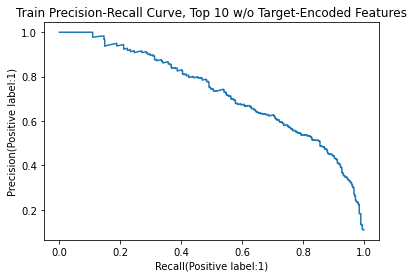

In [118]:
# plot train PR Curve 
train_precision6, train_recall6, train_thresholds6 = precision_recall_curve(y_train, y_train_proba6[:, 1])
train_auc_precision_recall6 = auc(train_recall6, train_precision6)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall6))

print('min threshold:{:.2f}'.format(min(train_thresholds6)), 'max threshold:{:.2f}'.format(max(train_thresholds6)))

plt.plot(train_recall6, train_precision6)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top 10 w/o Target-Encoded Features')

Test PR-AUC is 0.71
min threshold:0.08 max threshold:1.00


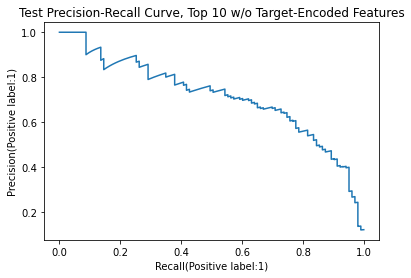

In [119]:
#from sklearn.metrics import auc,plot_precision_recall_curve
#from sklearn.metrics import precision_recall_curve

test_precision6, test_recall6, test_thresholds6 = precision_recall_curve(y_test, y_test_proba6[:, 1])
test_auc_precision_recall6 = auc(test_recall6, test_precision6)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall6))

print('min threshold:{:.2f}'.format(min(test_thresholds6)), 'max threshold:{:.2f}'.format(max(test_thresholds6)))

plt.plot(test_recall6, test_precision6)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top 10 w/o Target-Encoded Features')
plt.show()

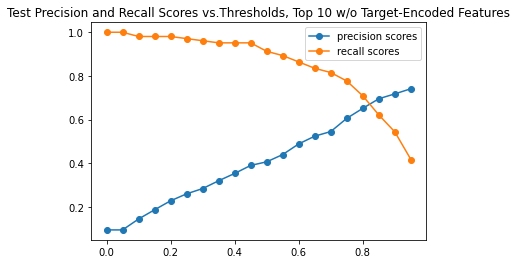

In [120]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores6 = []
recall_scores6 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model6.predict_proba(X_test_top10_2)[:,1]>thresholds[i]).astype(int)
    prec_scores6.append(precision_score(y_test, y_test_pred_new))
    recall_scores6.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores6, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores6,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 10 w/o Target-Encoded Features')
plt.show()

### Check collinearity between Top 10 features

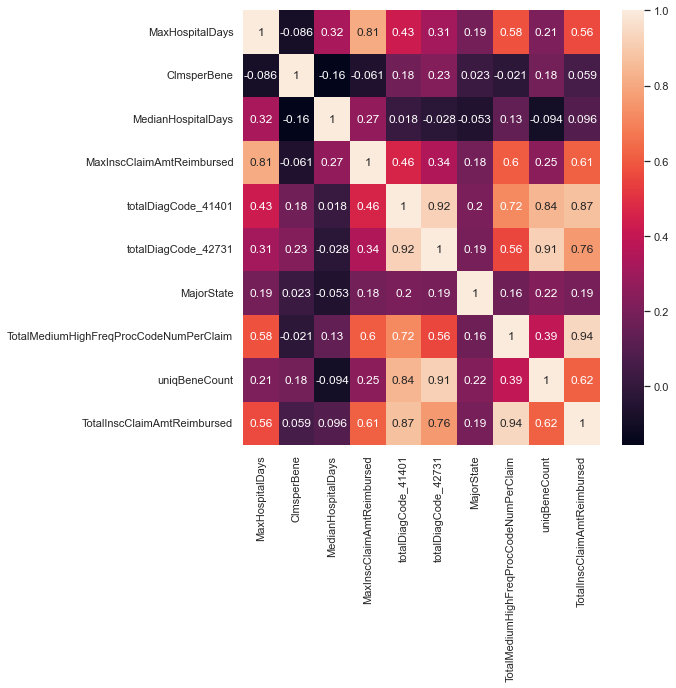

In [123]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})
dataplot=sns.heatmap(X_train_top10_2.corr(method = 'pearson'), annot=True)
plt.show()

TotalMediumHighFreqProcCodeNumPerClaim - TotalInscClaimAmReimbursed
<br>TotalDiacode_42731 - uniqBeneCount - TotalDiagCode_41401

## Remove 3 highly correlated features and re-train logistic Regression

In [125]:
to_be_removed = ['TotalMediumHighFreqProcCodeNumPerClaim','totalDiagCode_42731','totalDiagCode_41401']
top7features = []
for item in top10features2:
    if item not in to_be_removed:
        top7features.append(item)
top7features

['MaxHospitalDays',
 'ClmsperBene',
 'MedianHospitalDays',
 'MaxInscClaimAmtReimbursed',
 'MajorState',
 'uniqBeneCount',
 'TotalInscClaimAmtReimbursed']

In [126]:
X_train_top7 = X_train[top7features]
X_test_top7 = X_test[top7features]

display(X_train_top7.shape, X_test_top7.shape)

(4328, 7)

(1082, 7)

In [127]:
from sklearn.model_selection import GridSearchCV
param_grid = {'logreg__C':[10, 1.0, 0.1, 0.01,0.005],'logreg__penalty':['l2'], 'logreg__solver':['newton-cg','lbfgs','liblinear','sag','saga']}

steps7 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(class_weight = 'balanced',random_state=42,max_iter=10000))]
model7 = Pipeline(steps7)
model7_gsv = GridSearchCV(model7,param_grid,cv = 5, scoring = 'average_precision')
model7_gsv.fit(X_train_top7, y_train)
model7_gsv.best_params_

{'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

In [128]:
steps7 = [('rescale', StandardScaler()), 
          ('logreg', LogisticRegression(C = 0.01, penalty = 'l2', solver = 'liblinear', class_weight = 'balanced',random_state=42,max_iter=10000))]
model7 = Pipeline(steps7)
train_scores7= cross_val_score(model7, X_train_top7, y_train, scoring = 'average_precision', cv=5)
train_scores7.mean()

0.713541191215571

In [129]:
model7.fit(X_train_top7, y_train)

y_train_pred7 = model7.predict(X_train_top7)
y_train_proba7 = model7.predict_proba(X_train_top7)

y_test_pred7 = model7.predict(X_test_top7)
y_test_proba7 = model7.predict_proba(X_test_top7)

Text(0.5, 1.0, 'Train ROC Curve, Top 7 Select features')

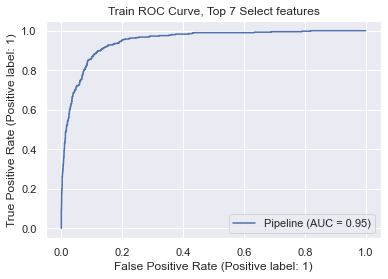

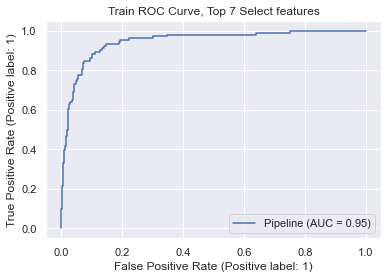

In [131]:
#ROC Curve
sns.set(rc={'figure.figsize':(6,4)})
RocCurveDisplay.from_estimator(model7, X_train_top7, y_train)
plt.title("Train ROC Curve, Top 7 Select features")
RocCurveDisplay.from_estimator(model7, X_test_top7, y_test)
plt.title("Train ROC Curve, Top 7 Select features")

Train PR-AUC is 0.72
min threshold:0.08 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Top 7 Select features, PR-AUC=0.72')

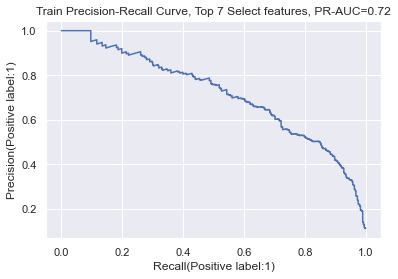

In [139]:
# plot train PR Curve 
train_precision7, train_recall7, train_thresholds7 = precision_recall_curve(y_train, y_train_proba7[:, 1])
train_auc_precision_recall7 = auc(train_recall7, train_precision7)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall7))

print('min threshold:{:.2f}'.format(min(train_thresholds7)), 'max threshold:{:.2f}'.format(max(train_thresholds7)))

plt.plot(train_recall7, train_precision7)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Top 7 Select features, PR-AUC=0.72')

Test PR-AUC is 0.71
min threshold:0.08 max threshold:1.00


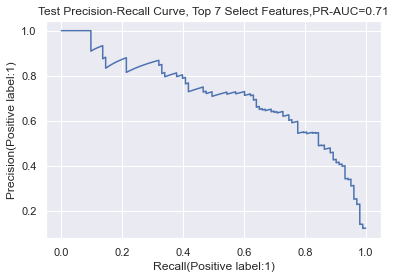

In [135]:
#from sklearn.metrics import auc,plot_precision_recall_curve
#from sklearn.metrics import precision_recall_curve

test_precision7, test_recall7, test_thresholds7 = precision_recall_curve(y_test, y_test_proba7[:, 1])
test_auc_precision_recall7 = auc(test_recall7, test_precision7)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall7))

print('min threshold:{:.2f}'.format(min(test_thresholds7)), 'max threshold:{:.2f}'.format(max(test_thresholds7)))

plt.plot(test_recall7, test_precision7)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, Top 7 Select Features,PR-AUC=0.71')
plt.show()

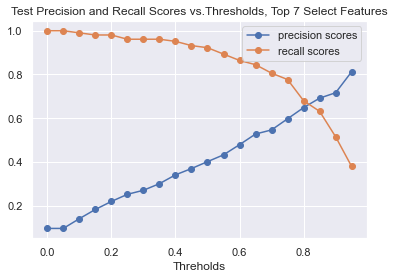

In [136]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores7 = []
recall_scores7 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model7.predict_proba(X_test_top7)[:,1]>thresholds[i]).astype(int)
    prec_scores7.append(precision_score(y_test, y_test_pred_new))
    recall_scores7.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores7, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores7,marker = 'o',label = 'recall scores')
plt.title('Test Precision and Recall Scores vs.Thresholds, Top 7 Select Features')
plt.xlabel('Threholds')
plt.legend()
plt.show()

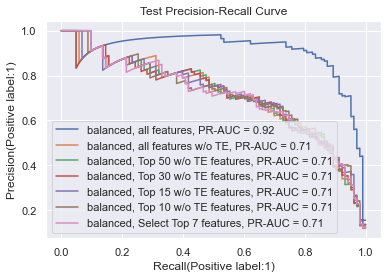

In [141]:
# Summary Test PR-Curve
line1, = plt.plot(test_recall1, test_precision1,label= 'balanced, all features, PR-AUC = 0.92')
line2, = plt.plot(test_recall2, test_precision2,label= 'balanced, all features w/o TE, PR-AUC = 0.71')
line3, = plt.plot(test_recall3, test_precision3,label= 'balanced, Top 50 w/o TE features, PR-AUC = 0.71')
line4, = plt.plot(test_recall4, test_precision4,label= 'balanced, Top 30 w/o TE features, PR-AUC = 0.71')
line5, = plt.plot(test_recall5, test_precision5,label= 'balanced, Top 15 w/o TE features, PR-AUC = 0.71')
line6, = plt.plot(test_recall6, test_precision6,label= 'balanced, Top 10 w/o TE features, PR-AUC = 0.71')
line7, = plt.plot(test_recall7, test_precision7,label= 'balanced, Select Top 7 features, PR-AUC = 0.71')

plt.legend(handles=[line1, line2,line3, line4, line5, line6, line7])
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve')
plt.show()

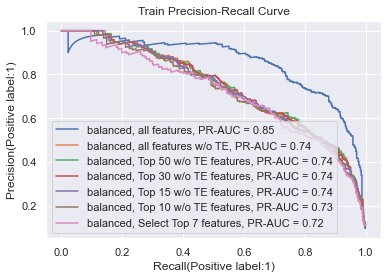

In [144]:
# Summary Train PR Curve
line1, = plt.plot(train_recall1, train_precision1,label= 'balanced, all features, PR-AUC = 0.85')
line2, = plt.plot(train_recall2, train_precision2,label= 'balanced, all features w/o TE, PR-AUC = 0.74')
line3, = plt.plot(train_recall3, train_precision3,label= 'balanced, Top 50 w/o TE features, PR-AUC = 0.74')
line4, = plt.plot(train_recall4, train_precision4,label= 'balanced, Top 30 w/o TE features, PR-AUC = 0.74')
line5, = plt.plot(train_recall5, train_precision5,label= 'balanced, Top 15 w/o TE features, PR-AUC = 0.74')
line6, = plt.plot(train_recall6, train_precision6,label= 'balanced, Top 10 w/o TE features, PR-AUC = 0.73')
line7, = plt.plot(train_recall7, train_precision7,label= 'balanced, Select Top 7 features, PR-AUC = 0.72')

plt.legend(handles=[line1, line2,line3, line4, line5, line6, line7])
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve')
plt.show()

In [143]:
X_train_top7.head()

,MaxHospitalDays,ClmsperBene,MedianHospitalDays,MaxInscClaimAmtReimbursed,MajorState,uniqBeneCount,TotalInscClaimAmtReimbursed
Provider,,,,,,,
PRV51001,15.0,1.041667,0.0,42000,1,24,104640
PRV51004,0.0,1.079710,0.0,3300,52,138,52170
PRV51005,0.0,2.353535,0.0,4080,25,495,280910
PRV51008,6.0,1.194444,0.0,21000,11,36,35630
PRV51011,6.0,1.094340,0.0,5000,1,53,16630


In [129]:
pip install virtualenv

  Using cached virtualenv-20.16.3-py2.py3-none-any.whl (8.8 MB)
Note: you may need to restart the kernel to use updated packages.
